In [45]:
import tools
from sympy import *
from scipy import signal,constants
from numpy import *
import sympy
import matplotlib.pyplot as plt

In [46]:
#Useful functions
def parallel_impedance(*arg):
    impedances = asarray(arg)
    parallel_impedance = 1/sum(1/impedances)
    return simplify(parallel_impedance)


# Introduction

This notebook is aimed at the analysis of an Differential and Amplifying circuit meant for Noise and differnetial analysis of transistors.

<img src="images\ElectricalCircuitSimplified.PNG " alt="Circuit" style="width:1000px;"/>

## Creation of component variables

In [47]:

R1 = Symbol('R1', complex=False)
R2 = Symbol('R2', complex=False)
R3 = Symbol('R3', complex=False)
RG = Symbol('RG', complex=False)

def G(RG):
    return 1+6e3/RG


C1 = Symbol('C1', complex=False)
C2 = Symbol('C2', complex=False)
C3 = Symbol('C3', complex=False)

omega = Symbol('omega', real=True)
C1_imp = 1/ (I*omega*C1)
C2_imp = 1/ (I*omega*C2)
C3_imp = 1/ (I*omega*C3)

VDD = Symbol('VDD', complex=False)
VSS = Symbol('VSS', complex=False)
Vref = Symbol('Vref', complex=False)

i_in_p = Symbol('i_in_p', complex=False)
i_in_m = Symbol('i_in_m', complex=False)


In [48]:
num_values = tools.read_yaml_file(tools.config_file)

syms_pass = [R1, R2, R3, RG, C1, C2, C3, VDD, VSS, Vref]
vals_pass = [num_values['R1'],
num_values['R2'],
num_values['R3'],
num_values['RG'],
num_values['C1'],
num_values['C2'],
num_values['C3'],
num_values['VDD'],
num_values['VSS'],
num_values['Vref']]


def get_num_val_passive(expr):
    for sym,val in zip(syms_pass,vals_pass):
        expr = expr.subs(sym,val)
    return expr

# Circuit topology

The circuit is composed of two stages disposed sequentialy. The first stage apears twice and the both output goes to the two inputs of the second stage.

## First stage topology

This stage is meant for amplifying and filtering purposes. An Operationnal Amplifier is used as a Transimpedance to convert the input current to an output voltage.

The use of a RC loop is for a Low Pass filtering usage. For Noise analysis the cutting frequency is meant to be sufficiently high to get the most beneficial data as possible whilst still being able to concatenate the frequency range. The second purpose of the RC loop is for amplifying the input current to a more tangible voltage for the second stage.

Depending on the current direction and the input configuration before this circuit, a Vref voltage can be applyied at the non-inverting entery of the amplifier. This reference voltage is filtered to be as constant as possible with decoupling capacitor.

## Second stage topology

This second stage will apply the difference between the two ingoing input current. A gain can be useful for some applications but in this second stage one can use a gain equal to 1 if the output readying sensor allows low voltage measurements.

This second stage has to have a low input noise voltage has it can not be filter out afterwards (at least int this configuration).

# Output Analysis

Has the input current can go up to $1mA$, the analysis of the full circuit working range has to be done. In fact, one has to avoid the sturation of both stages amplifiers as it obviously corrupts the data.

this is the equivalent of a DC analysis



## First stage working range

The first stage can be moldeled as follows:


<img src="images\1stStage.PNG " alt="Circuit" style="width:300px;"/>

Therefore:

\begin{align}
    V_{out\_1} &= i_{in}Z_1 + V_{ref} \tag{1} \\
    Z_1 &= R_1 || C_1 \tag{2}
\end{align}

In [49]:
i_in = Symbol('i_in')
Z_1 = parallel_impedance(R1,C1_imp)
V_out_1= i_in*Z_1 +Vref
V_out_1_DC = V_out_1.subs(I*omega,0)
print("V_out_1 =",V_out_1)

V_out_1 = R1*i_in/(I*C1*R1*omega + 1) + Vref


## Second stage

The second stage can be modeled as:

<img src="images\2ndStage.PNG " alt="Circuit" style="width:300px;"/>

Therefore:

\begin{align}
    \Delta V_{in} &= V_{in\_p}-V_{in\_m} \tag{3} \\
    V_{out} &= \Delta V_{in}G \tag{4}
\end{align}

$G \equiv G(R_G)$ being the gain depending on $R_G$ gain of the differential amplifier.

In [50]:
dV_in = Symbol('dV_in')

V_out_2 = dV_in * G(RG)
V_out_2_DC = V_out_2.subs(I*omega,0)
print("V_out =",V_out_2)

V_out = dV_in*(1 + 6000.0/RG)


## Full circuit analysis

\begin{align}
    V_{in\_p} &= V_{out\_1}(i_{in\_p}) \tag{5} \\
    V_{in\_m} &= V_{out\_1}(i_{in\_m}) \tag{6}
\end{align}

Therefor we get $V_{out}$:

In [51]:
di_in = Symbol('di_in')
V_in_p = V_out_1.subs(i_in,i_in_p)
V_in_m = V_out_1.subs(i_in,i_in_m)
V_out = simplify(V_out_2.subs(dV_in,V_in_p-V_in_m)).subs(i_in_p-i_in_m,di_in)


print("V_out =",V_out)

V_out = R1*di_in*(RG + 6000.0)/(RG*(I*C1*R1*omega + 1))


Finally for a DC only input we get:

In [52]:
V_out_DC = V_out.subs(I*omega,0)

print("V_out_DC =",V_out_DC)

V_out_DC = R1*di_in*(RG + 6000.0)/RG


In [53]:
Z_ref = parallel_impedance(R2,C2,C3)
C = Symbol('C')

V_in_w_N_1 = Symbol('V_in_w_N_1')
i_in_w_N_1 = Symbol('i_in_w_N_1')
V_in_c_f_1 = Symbol('V_in_c_f_1')
i_in_c_f_1 = Symbol('i_in_c_f_1')
V_in_w_N_2 = Symbol('V_in_w_N_2')
i_in_w_N_2 = Symbol('i_in_w_N_2')
V_in_c_f_2 = Symbol('V_in_c_f_2')
i_in_c_f_2 = Symbol('i_in_c_f_2')
V_out_N_2 = Symbol('V_out_N_2')
T = Symbol('T')

syms_noise = [V_in_w_N_1, i_in_w_N_1, V_in_c_f_1, i_in_c_f_1, V_in_w_N_2, i_in_w_N_2, V_in_c_f_2, i_in_c_f_2, V_out_N_2, T]
vals_noise = [float(num_values['V_in_w_N_1']),
float(num_values['i_in_w_N_1']),
2*pi*float(num_values['V_in_c_f_1']),
2*pi*float(num_values['i_in_c_f_1']),
float(num_values['V_in_w_N_2']),
float(num_values['i_in_w_N_2']),
2*pi*float(num_values['V_in_c_f_2']),
2*pi*float(num_values['i_in_c_f_2']),
float(num_values['V_out_N_2']),
float(num_values['T'])]

def get_num_val_noise(expr):
    for sym,val in zip(syms_noise,vals_noise):
        expr = expr.subs(sym,val)
    return expr


V_in_1_f_N_1 = sympy.solve(C/V_in_c_f_1 - V_in_w_N_1,C)[0]/(omega/(2*pi))
print(V_in_1_f_N_1)
i_in_1_f_N_1 = sympy.solve(C/i_in_c_f_1 - i_in_w_N_1,C)[0]/(omega/(2*pi))
V_in_1_f_N_2 = sympy.solve(C/V_in_c_f_2 - V_in_w_N_2,C)[0]/(omega/(2*pi))
i_in_1_f_N_2 = sympy.solve(C/i_in_c_f_2 - i_in_w_N_2,C)[0]/(omega/(2*pi))

6.28318530717959*V_in_c_f_1*V_in_w_N_1/omega


# Transfer functions

We will explicitise the transfer function to use it later on.

## Seen from the first stage

In [54]:
tf_1_p_v = 1
tf_1_p_i = Z_ref
tf_1_m_v = 1
tf_1_m_i = V_out/di_in

## Seen from the second stage

In [55]:
tf_2 = V_out_2/dV_in

# Noise from the circuit Analysis

The passive and active elements of the circuit bring noise to the data acquirements.

According to integration characteristics of the OpAmp of the first stage and the differential amplifier of the second, the equivalent noise circuit is presented has follows:

<img src="images\Noisecircuit.PNG " alt="Circuit" style="width:800px;"/>

The noise at the output can be explained as follows:

\begin{align}
    S_{n,tot}(f) = \sqrt{\sum|H_i(j\omega)|^2S_{n,i}(\omega)} \tag{7}
\end{align}


In [71]:
def thermal_noise_vsd(impedance,T):
    return simplify(4*Symbol('k')*Symbol('T')*re(impedance))

Sn_i_H_i = array([
    [thermal_noise_vsd(Z_ref,T),tf_1_p_v],
    [thermal_noise_vsd(Z_1,T),tf_1_m_v],
    [i_in_w_N_1,tf_1_p_i],
    [V_in_w_N_1,tf_1_p_i],
    [i_in_1_f_N_1,tf_1_p_i],
    [V_in_1_f_N_1,tf_1_p_i],
    [i_in_w_N_1,tf_1_m_i],
    [i_in_w_N_2,tf_1_p_v],
    [i_in_1_f_N_1,tf_1_m_i],
    [i_in_1_f_N_2,tf_1_p_v],
    [i_in_w_N_1,tf_1_p_i],
    [V_in_w_N_1,tf_1_p_i],
    [i_in_1_f_N_1,tf_1_p_i],
    [V_in_1_f_N_1,tf_1_p_i],
    [i_in_w_N_1,tf_1_m_i],
    [i_in_w_N_2,tf_1_p_v],
    [i_in_1_f_N_1,tf_1_m_i],
    [i_in_1_f_N_2,tf_1_p_v],
    [V_in_w_N_2,tf_2],
    [V_out_N_2,1],
    # [thermal_noise_vsd(RG,T),1],
])
Sn_i = Sn_i_H_i[:,0]
H_i = Sn_i_H_i[:,1]


S_n_tot = absolute(power(H_i,2))@Sn_i
print_latex(S_n_tot)
S_n_tot_num = together(get_num_val_noise(get_num_val_passive(S_n_tot)))

# print(S_n_tot_num)

# w = logspace(1,6,num=300)

# S_n_tot_num_plot = lambdify(omega, absolute(S_n_tot_num), "numpy")

# plt.figure()
# plt.semilogx(w, sqrt(S_n_tot_num_plot(w)))    # Bode magnitude plot
# print(float(S_n_tot_num.subs(omega,2)))


4 T k \operatorname{re}{\left(\frac{C_{2} C_{3} R_{2}}{C_{2} C_{3} + C_{2} R_{2} + C_{3} R_{2}}\right)} + \frac{12000.0 T k}{9.0 \cdot 10^{-18} \omega^{2} + 1} + \frac{12.5663706143592 V_{in c f 1} V_{in w N 1} \left|{\frac{C_{2}^{2} C_{3}^{2} R_{2}^{2}}{\left(C_{2} C_{3} + C_{2} R_{2} + C_{3} R_{2}\right)^{2}}}\right|}{\omega} + 2 V_{in w N 1} \left|{\frac{C_{2}^{2} C_{3}^{2} R_{2}^{2}}{\left(C_{2} C_{3} + C_{2} R_{2} + C_{3} R_{2}\right)^{2}}}\right| + 36000000.0 V_{in w N 2} \left|{\left(0.000166666666666667 + \frac{1}{RG}\right)^{2}}\right| + V_{out N 2} + \frac{12.5663706143592 i_{in c f 1} i_{in w N 1} \left|{\frac{C_{2}^{2} C_{3}^{2} R_{2}^{2}}{\left(C_{2} C_{3} + C_{2} R_{2} + C_{3} R_{2}\right)^{2}}}\right|}{\omega} + \frac{452389342.11693 i_{in c f 1} i_{in w N 1} \left|{\frac{R_{1}^{2} \left(0.000166666666666667 RG + 1\right)^{2}}{RG^{2} \left(i C_{1} R_{1} \omega + 1\right)^{2}}}\right|}{\omega} + \frac{12.5663706143592 i_{in c f 2} i_{in w N 2}}{\omega} + 2 i_{in w N 1} \l

In [72]:
S_n_tot.simplify()

(12000.0*T*k*omega + omega*(9.0e-18*omega**2 + 1)*(4*T*k*re(C2*C3*R2/(C2*C3 + C2*R2 + C3*R2)) + 2*V_in_w_N_1*Abs(C2**2*C3**2*R2**2/(C2*C3 + C2*R2 + C3*R2)**2) + 36000000.0*V_in_w_N_2*Abs((0.000166666666666667*RG + 1)**2/RG**2) + V_out_N_2 + 2*i_in_w_N_1*Abs(C2**2*C3**2*R2**2/(C2*C3 + C2*R2 + C3*R2)**2) + 72000000.0*i_in_w_N_1*Abs(R1**2*(0.000166666666666667*RG + 1)**2/(RG**2*(I*C1*R1*omega + 1)**2)) + 2*i_in_w_N_2) + (9.0e-18*omega**2 + 1)*(12.5663706143592*V_in_c_f_1*V_in_w_N_1*Abs(C2**2*C3**2*R2**2/(C2*C3 + C2*R2 + C3*R2)**2) + 12.5663706143592*i_in_c_f_1*i_in_w_N_1*Abs(C2**2*C3**2*R2**2/(C2*C3 + C2*R2 + C3*R2)**2) + 452389342.11693*i_in_c_f_1*i_in_w_N_1*Abs(R1**2*(0.000166666666666667*RG + 1)**2/(RG**2*(I*C1*R1*omega + 1)**2)) + 12.5663706143592*i_in_c_f_2*i_in_w_N_2))/(omega*(9.0e-18*omega**2 + 1))

# Swipping Range Analysis

The OpAmp are powered by VDD and VSS. We know that if the output is suppose to be higher than VDD or loweer than VSS the OpAmp will saturate at the boundary.

## First stage working range

<class 'numpy.ndarray'>


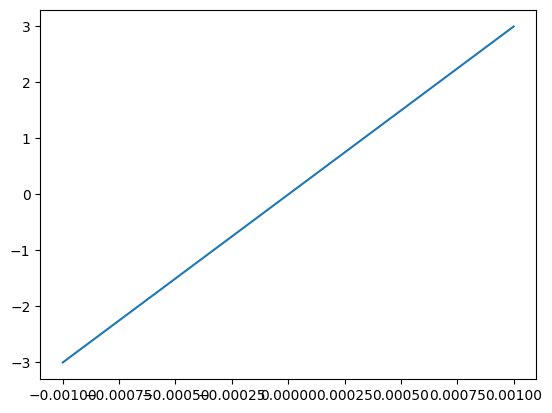

In [57]:
V_out_1_DC_num = get_num_val_passive(V_out_1_DC)

nb_points_plot = 2
i_wide_range = [-1e-3,1e-3]
i_plot = linspace(*i_wide_range,nb_points_plot)
V_out_1_DC_num = lambdify(i_in, V_out_1_DC_num, "numpy")
print(type(V_out_1_DC_num(i_plot)))
plt.plot(i_plot,V_out_1_DC_num(i_plot))


# Numerical application

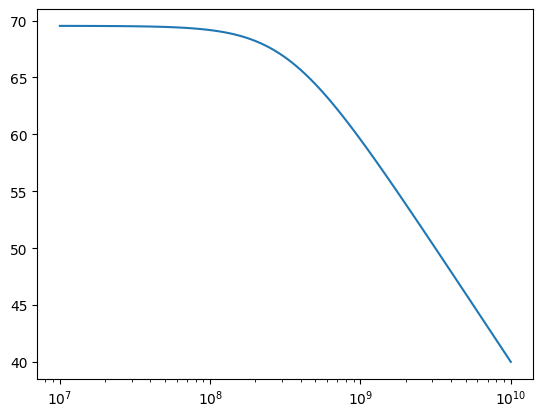

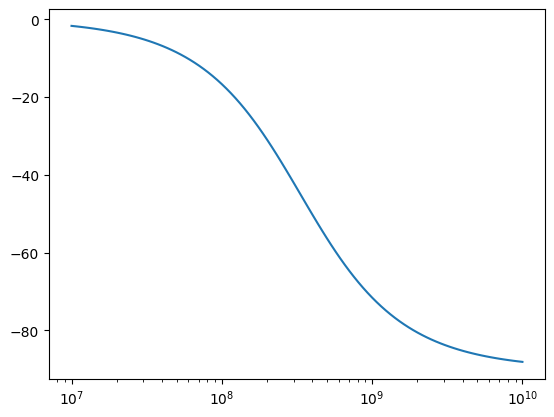

In [58]:
Z_1 = get_num_val_passive(Z_1)
zeros,poles = fraction(Z_1)
zeros_coeff = [float(absolute(coeff)) for coeff in Poly(zeros,omega).all_coeffs()]
poles_coeff = [float(absolute(coeff)) for coeff in Poly(poles,omega).all_coeffs()]

stage1_tf = signal.TransferFunction(zeros_coeff,poles_coeff)
w, mag, phase = signal.bode(stage1_tf)

plt.figure()
plt.semilogx(w, mag)    # Bode magnitude plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.show()

In [59]:
V_out_1_DC_sat_p = get_num_val_passive(V_out_1_DC-VDD)
V_out_1_DC_sat_m = get_num_val_passive(V_out_1_DC-VSS)
i_min_1 = min([solve(V_out_1_DC_sat_m),solve(V_out_1_DC_sat_p)])[0]
i_max_1 = max([solve(V_out_1_DC_sat_m),solve(V_out_1_DC_sat_p)])[0]
print(i_min_1,i_max_1)

-0.00166666666666667 0.00166666666666667
